**Najdi funkci $u$ na oblasti $\Omega = (0, 1) \times (0, 1)$ splňující:**
$$\begin{align*}
    -\Delta u &= f \qquad \text{na } \Omega \\
    u &= 0 \qquad \text{na } \partial\Omega
\end{align*}$$

**Přesné řešení:**\
Položme $u(x,y) = x(1-x)y(1-y)$. Snadno se ověří, že $u(x, y) = 0$ na $\partial\Omega$. Spočtěme Laplacián:
$$\begin{equation*}
    \Delta u = 2(x^2 + y^2 - x - y).
\end{equation*}$$
Volme funkci $f$ právě takto:
$$\begin{equation*}
    f(x, y) = -2(x^2 + y^2 - x - y).
\end{equation*}$$
Z toho je již však vidno, že dvojice $u, f$ je přesným řešením úlohy. \
Níže budeme trénovat model řešící tuto úlohu, a poté jej porovnáme s přesným řešením.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Zakladni import
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import sys

In [10]:
# Import vlastnich modulu
sys.path.append('../')
from src.models.mlp_model import MLPModel
import src.data.square_domain as sq
from src import train
from src import calculus as calc
from src import utils

In [11]:
# Volba vhodneho device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# definice funkce f(x, y)
def f(x: torch.Tensor) -> torch.Tensor:
    return -2 * (x[:, 0]**2 + x[:, 1]**2 - x[:, 0] - x[:, 1])

In [13]:
# Definice ztratove funkce
def loss_fn(model: nn.Module, domain: SquareDomain) -> torch.Tensor:
    u_lapl = calc.laplacian_2d(model, domain.interior)
    f_vals = f(domain.interior)
    inner_loss = torch.mean((-u_lapl - f_vals) ** 2)
    
    total_bnd = torch.cat([domain.left_boundary,
                          domain.right_boundary,
                          domain.top_boundary,
                          domain.bottom_boundary], dim=0)

    u_bnd = model(total_bnd)
    bnd_loss = torch.mean((u_bnd) ** 2)

    return inner_loss + bnd_loss

In [14]:
# Definice modelu
model = MLPModel(input_dim=2, output_dim=1, hidden_dim=[20, 20]).to(device)
# Definice domeny
config = sq.SquareDomainConfig(
    x_0=0,
    x_1=1,
    y_0=0,
    y_1=1,
    device=device
)

domain = sq.SquareDomain(config)
# Definice optimizeru
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Definice scheduleru
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

In [15]:
# Spusteni trenovani
context = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    scheduler=scheduler,
    epochs=10_000
)

loss_values = train.simple_train(ctx=context)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss at epoch 1 is: 0.39245766401290894
Loss at epoch 100 is: 0.05977100506424904
Loss at epoch 200 is: 0.04925994575023651
Loss at epoch 300 is: 0.04732869938015938
Loss at epoch 400 is: 0.046148329973220825
Loss at epoch 500 is: 0.04785003513097763
Loss at epoch 600 is: 0.04644472524523735
Loss at epoch 700 is: 0.04434362053871155
Loss at epoch 800 is: 0.04455677792429924
Loss at epoch 900 is: 0.04453526809811592
Loss at epoch 1000 is: 0.04273774474859238
Loss at epoch 1100 is: 0.039919909089803696
Loss at epoch 1200 is: 0.04315625876188278
Loss at epoch 1300 is: 0.04407216235995293
Loss at epoch 1400 is: 0.04534289985895157
Loss at epoch 1500 is: 0.044312428683042526
Loss at epoch 1600 is: 0.04421642795205116
Loss at epoch 1700 is: 0.042231637984514236
Loss at epoch 1800 is: 0.046172577887773514
Loss at epoch 1900 is: 0.044559236615896225
Loss at epoch 2000 is: 0.043050367385149
Loss at epoch 2100 is: 0.04693439230322838
Loss at epoch 2200 is: 0.046334803104400635
Loss at epoch 2300

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


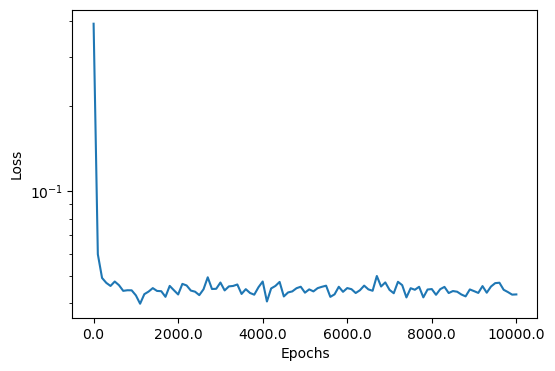

In [16]:
# Vykresleni ztraty
utils.plot_loss_values(loss_values, 'Epochs', 'Loss')

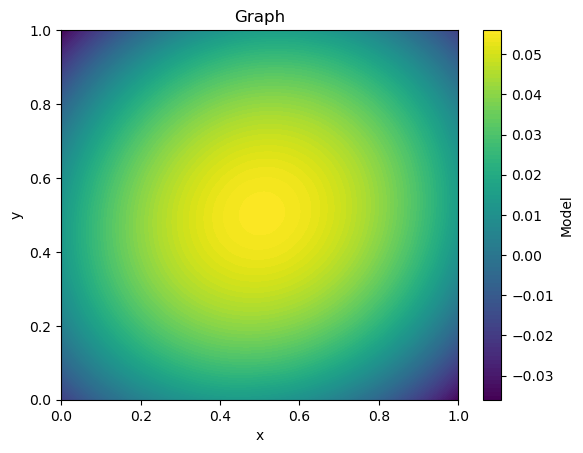

In [18]:
# Kontrola vysledku
# prvne vykreslime trenovaci ztratu
utils.plot_function_on_domain(function=model, domain=domain, function_name='Model')

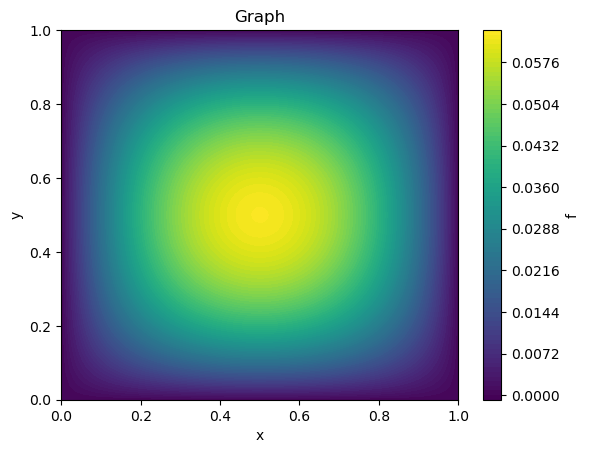

In [ ]:
# Nyni vykreslime spravne reseseni
def u(x: torch.Tensor) -> torch.Tensor:
    return x[:, 0]*(1 - x[:, 0])*x[:, 1]*(1 - x[:, 1])

utils.plot_function_on_domain(function=u, domain=domain, function_name='f')